# **Smarter anomaly detection** - Generating a synthetic time series dataset
*Preliminary part - Synthetic data generation*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from dateutil.relativedelta import relativedelta

random.seed(42)

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

In [3]:
START = '2021-01-01 00:00'
END   = '2021-12-31 23:50'

# Set the frequency using this format in minutes:
FREQ = '10min'

index = pd.date_range(start=START, end=END, freq=FREQ)
df = pd.DataFrame({'timestamp': index})
df = df.set_index('timestamp')

## Base signal generation
---

### Random signal

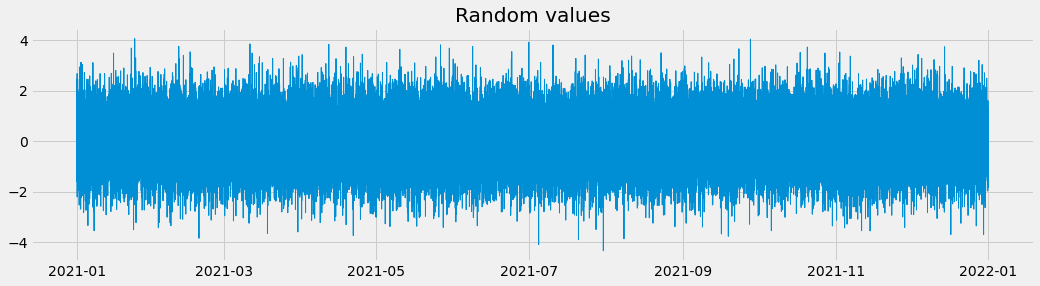

In [4]:
df['value'] = np.random.normal(0, 1, len(index))

fig = plt.figure(figsize=(16,4))
plt.plot(df)
plt.title('Random values')
plt.show()

### Leveraging a random walk process
#### Helper function

In [5]:
def generate_random_walk(
    num_values,
    start=0, 
    step=1,
    probability=0.5, 
    min_value=-np.inf, 
    max_value=np.inf
):
    previous_value = start
    array = np.zeros((num_values,))
    for index in range(num_values):
        if previous_value < min_value:
            previous_value = min_value
        if previous_value > max_value:
            previous_value = max_value
            
        p = random.random()
        if p >= probability:
            array[index] = previous_value + step
        else:
            array[index] = previous_value - step
            
        previous_value = array[index]
        
    return array

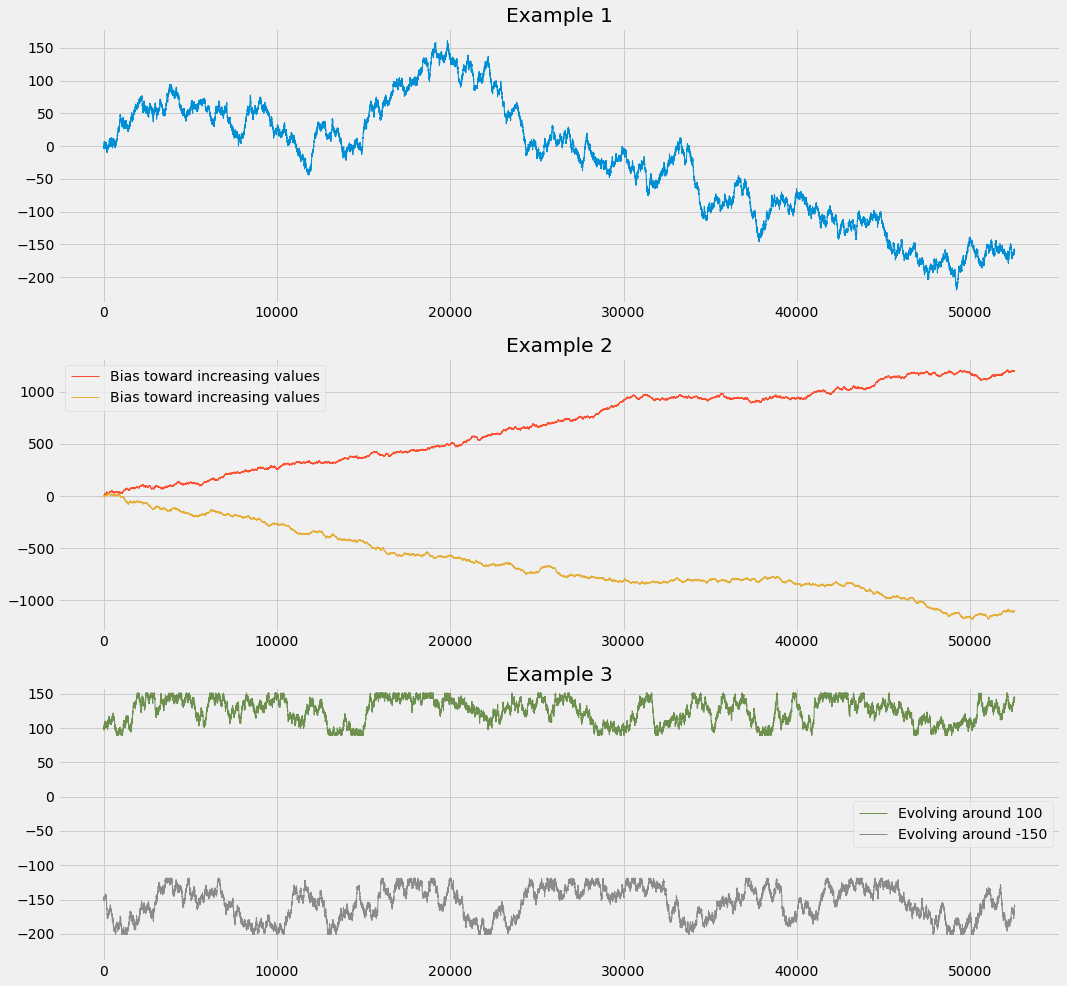

In [6]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(3,1,1)
ax.plot(generate_random_walk(df.shape[0]))
ax.set_title('Example 1')

ax = fig.add_subplot(3,1,2)
ax.plot(generate_random_walk(df.shape[0], probability=0.49), label='Bias toward increasing values', color=colors[1])
ax.plot(generate_random_walk(df.shape[0], probability=0.51), label='Bias toward increasing values', color=colors[2])
ax.legend()
ax.set_title('Example 2')

ax = fig.add_subplot(3,1,3)
ax.plot(generate_random_walk(df.shape[0], probability=0.5, start=100, min_value=90, max_value=150), label='Evolving around 100', color=colors[3])
ax.plot(generate_random_walk(df.shape[0], probability=0.5, start=-150, min_value=-200, max_value=-120), label='Evolving around -150', color=colors[4])
ax.legend()
ax.set_ylim(-240, 160)
ax.set_title('Example 3')

plt.show()

#### Generating a multivariate datasets

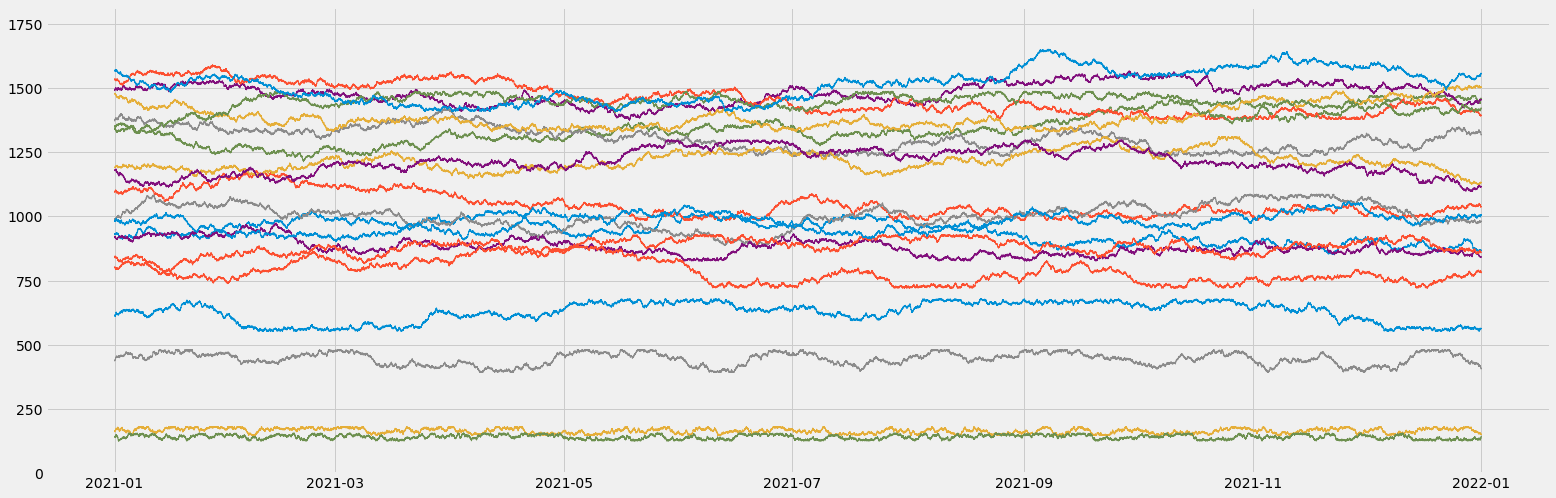

In [7]:
NUM_TIMESERIES = 20
STARTS = np.random.rand(NUM_TIMESERIES,) * 1500 + 100

df = df.drop('value', axis='columns')
for i in range(NUM_TIMESERIES):
    START = STARTS[i]
    STEP = abs(STARTS.max() / 2000.0)
    MIN = START * 0.9
    MAX = START * 1.1
    
    values = generate_random_walk(
        df.shape[0], 
        start=START, 
        probability=0.5, 
        step=STEP, 
        min_value=MIN, 
        max_value=MAX
    )
    df[f'signal_{i:02}'] = values
    
fig = plt.figure(figsize=(24,8))
plt.plot(df)
plt.ylim(0, df.max().max()*1.1)
plt.show()

## Adding anomalies
---

### Adding operating modes and anomalies

In the next notebook we will train a model over the first **5 months** of the year and evaluate it over the last **7 months**.

Based on the underlying signal generated previously, we will introduce the following behaviors:

1. *Different operating modes:* we will introduce two different modes in the training periods and introduce a third one in the evaluation periods. The anomaly detection should consider the 3rd mode as an anomaly as it will never have seen it at training time
2. *Slow degradation:* we will also introduce a slow degradation on one of the signal in the evaluation period
3. *Failure:* after the slow degradation, we will simulate a catastrophic failure where all the signals are reduced to 0.0

#### Adding different operating modes

In [8]:
def add_level_shift(series, freq, magnitude_shift, magnitude_multiply=None, start=None, end=None, duration=None):
    original_series = series.copy()
    # Converting frequency in minutes:
    freq = int(freq[:-3])
    
    if start is None:
        ANOMALY_START = original_series.index[int(random.random() * original_series.shape[0] * 0.75)]
    else:
        ANOMALY_START = start

    if (end is None) and (duration is None):
        # Durations unit are in number of datapoints. With a frequency of 5 minutes, 
        # we want to set a minimum duration of:
        # 1 week = 7 days x 24 hours x 12 (=60 minutes / 5 minutes)
        MIN_DURATION = 60 / freq * 24 * 7
        MAX_DURATION = 60 / freq * 24 * 30
        ANOMALY_DURATION = MIN_DURATION + int(random.random() * (MAX_DURATION - MIN_DURATION))
        ANOMALY_END = ANOMALY_START + relativedelta(minutes=+ANOMALY_DURATION * freq)
        
    elif end is not None:
        ANOMALY_END = end
        
    elif duration is not None:
        ANOMALY_END = ANOMALY_START + relativedelta(minutes=+duration * freq)

    index = pd.date_range(ANOMALY_START, ANOMALY_END, freq=f'{freq}min')
    anomaly_df = pd.Series(
        index=index,
        dtype=np.float64
    )
    anomaly_df.loc[:] = magnitude_shift
    
    if np.max(index) > np.max(original_series.index):
        anomaly_df = anomaly_df[:np.max(original_series.index)]
        
    if magnitude_multiply is not None:
        min_value = original_series[index].min()
        avg_value = original_series[index].mean()
        original_series[index] -= avg_value
        original_series[index] *= magnitude_multiply
        original_series[index] += avg_value

    new_series = original_series.add(anomaly_df, fill_value=0)
    
    return new_series

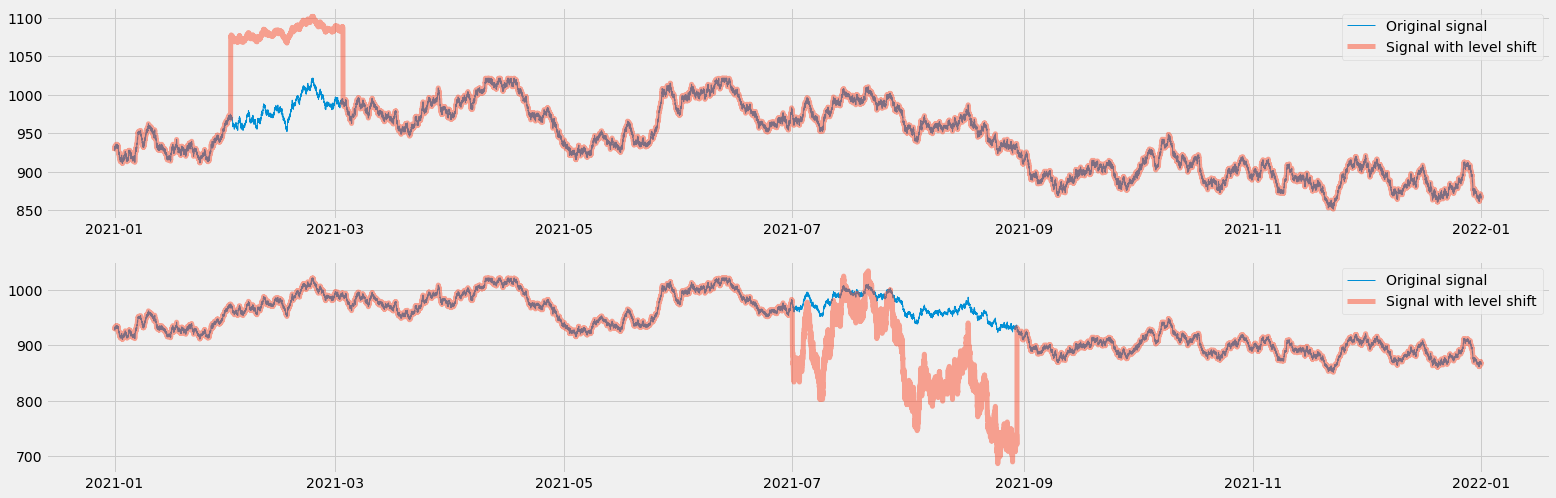

In [9]:
tags_list = list(df.columns)
tag = tags_list[0]

level_shift_start = pd.to_datetime('2021-02-01')
level_shift_duration = (60 / int(FREQ[:-3])) * 24 * 30
new_tag = add_level_shift(df[tag], freq=FREQ, magnitude_shift=100, magnitude_multiply=0.5, duration=level_shift_duration, start=level_shift_start)
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(2, 1, 1)
ax.plot(df[tag], linewidth=1.0, label='Original signal')
ax.plot(new_tag, linewidth=5.0, alpha=0.5, label='Signal with level shift')
ax.legend()

level_shift_start = pd.to_datetime('2021-07-01')
level_shift_duration = (60 / int(FREQ[:-3])) * 24 * 60
new_tag = add_level_shift(df[tag], freq=FREQ, magnitude_shift=-100, magnitude_multiply=4.0, duration=level_shift_duration, start=level_shift_start)
ax = fig.add_subplot(2, 1, 2)
ax.plot(df[tag], linewidth=1.0, label='Original signal')
ax.plot(new_tag, linewidth=5.0, alpha=0.5, label='Signal with level shift')
ax.legend()
plt.show()

In [10]:
tags_list = list(df.columns)
random_tags = random.sample(tags_list, 3)

# Adding this mode in training range:
level_shift_start = pd.to_datetime('2021-02-01')
level_shift_duration = (60 / int(FREQ[:-3])) * 24 * 30
for tag in random_tags:
    df[tag] = add_level_shift(df[tag], freq=FREQ, magnitude_shift=100, magnitude_multiply=0.5, duration=level_shift_duration, start=level_shift_start)
    
# Adding a similar mode in the evaluation range
level_shift_start = pd.to_datetime('2021-07-01')
level_shift_duration = (60 / int(FREQ[:-3])) * 24 * 10
for tag in random_tags:
    df[tag] = add_level_shift(df[tag], freq=FREQ, magnitude_shift=100, magnitude_multiply=0.5, duration=level_shift_duration, start=level_shift_start)

In [11]:
used_tags = random_tags
random_tags = random.sample(tags_list, 5)
used_tags = used_tags + random_tags

# Adding this mode only in the evaluation range:
level_shift_start = pd.to_datetime('2021-09-01')
level_shift_duration = (60 / int(FREQ[:-3])) * 24 * 5
for tag in random_tags:
    df[tag] = add_level_shift(df[tag], freq=FREQ, magnitude_shift=+250, magnitude_multiply=2.5, duration=level_shift_duration, start=level_shift_start)

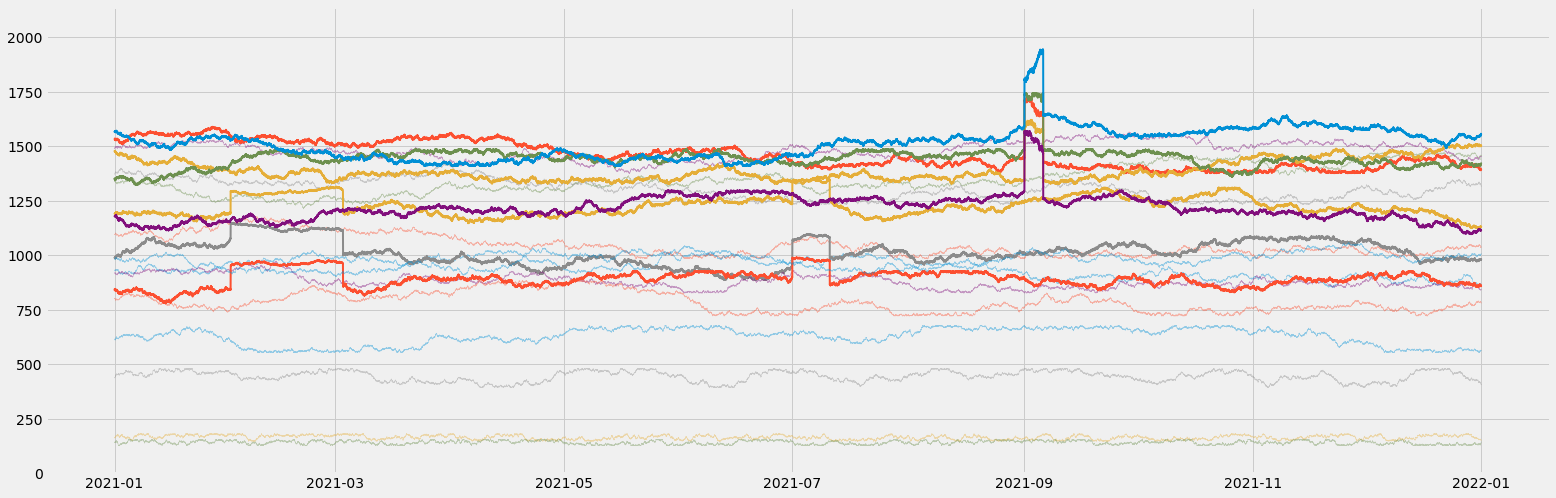

In [12]:
fig = plt.figure(figsize=(24,8))
for tag in df.columns:
    if tag in used_tags:
        plt.plot(df[tag], linewidth=2.0)
    else:
        plt.plot(df[tag], alpha=0.4, linewidth=0.5)
    
plt.ylim(0.0, df.max().max()*1.1)
plt.show()

#### Slow degradation

In [13]:
def add_degradation(
    series, 
    freq, 
    start=None, 
    end=None, 
    duration=None, 
    degradation_speed=0.05, 
    degradation_slope=-0.05, 
    degradation_duration=None
):
    original_series = series.copy()
    
    # Converting frequency in minutes:
    freq = int(freq[:-3])
    
    # Defines the start of the anomaly:
    if start is None:
        ANOMALY_START = original_series.index[int(random.random() * original_series.shape[0] * 0.75)]
    else:
        ANOMALY_START = start

    # Defines the end and the duration:
    if (end is None) and (duration is None):
        # Durations unit are in number of datapoints. With a frequency of 5 minutes, 
        # we want to set a minimum duration of:
        # 1 week = 7 days x 24 hours x 12 (=60 minutes / 5 minutes)
        MIN_DURATION = 60 / freq * 24 * 7
        MAX_DURATION = 60 / freq * 24 * 30
        ANOMALY_DURATION = MIN_DURATION + int(random.random() * (MAX_DURATION - MIN_DURATION))
        ANOMALY_END = ANOMALY_START + relativedelta(minutes=+ANOMALY_DURATION * freq)
        
    elif end is not None:
        ANOMALY_END = end
        
    elif duration is not None:
        ANOMALY_END = ANOMALY_START + relativedelta(minutes=+duration * freq)
        ANOMALY_DURATION = duration

    # Generates a new random walk for the anomaly:
    values = generate_random_walk(
        ANOMALY_DURATION + 1, 
        start=0.0, 
        probability=0.5 - degradation_slope, 
        step=degradation_speed
    )
    index = pd.date_range(ANOMALY_START, ANOMALY_END, freq=f'{freq}min')
    anomaly_df = pd.Series(index=index, dtype=np.float64)
    anomaly_df.loc[:] = values
    
    # Add 
    last_value = values[-1]
    original_series.loc[ANOMALY_END + relativedelta(minutes=+freq):] = series.loc[ANOMALY_END:] + last_value
    
    if degradation_duration is not None:
        DEGRADATION_END = ANOMALY_END + relativedelta(minutes=+degradation_duration * freq)
        original_series.loc[DEGRADATION_END:] = series.loc[DEGRADATION_END:]
    
    new_series = original_series.add(anomaly_df, fill_value=0)
    
    return new_series, anomaly_df

In [14]:
unused_tags = [t for t in df.columns if t not in used_tags]
random_tags = random.sample(unused_tags, 2)
tag1, tag2 = random_tags[0], random_tags[1]

df[tag1], anomaly_series_train = add_degradation(df[tag1], FREQ, start=pd.to_datetime('2021-03-15'), duration=int(60/int(FREQ[:-3]))*24*15, degradation_speed=1.0, degradation_slope=0.03, degradation_duration=(60/int(FREQ[:-3]))*24*7)
df[tag2], anomaly_series_eval = add_degradation(df[tag2], FREQ, start=pd.to_datetime('2021-10-01'), duration=int(60/int(FREQ[:-3]))*24*30, degradation_speed=1.0, degradation_slope=0.03, degradation_duration=(60/int(FREQ[:-3]))*24*10)

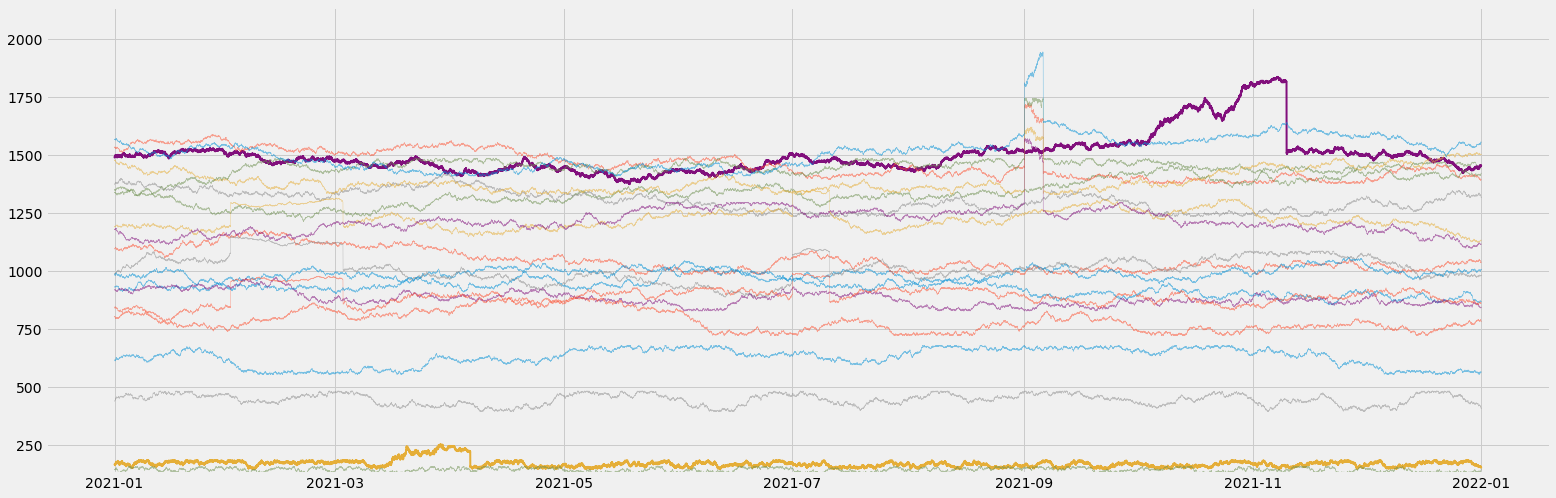

In [15]:
fig = plt.figure(figsize=(24,8))
for tag in tags_list:
    if tag in random_tags:
        plt.plot(df[tag], label=tag, linewidth=2.0)
    else:
        plt.plot(df[tag], label=tag, linewidth=0.5, alpha=0.5)

plt.ylim(df.min().min(), df.max().max()*1.1)
# plt.legend(ncol=len(tags_list), loc='upper left', fontsize=10)
plt.show()

#### Failure

In [16]:
def add_failure(series, start, duration, freq):
    freq = int(freq[:-3])
    original_series = series.copy()
    ANOMALY_START = start
    ANOMALY_DURATION = duration
    index = pd.date_range(ANOMALY_START, periods=ANOMALY_DURATION, freq=f'{freq}min')

    original_series.loc[index] = 0.0
    
    return original_series

In [17]:
random_tags = random.sample(tags_list, 6)
used_tags = random_tags
failure_duration = (60/int(FREQ[:-3]))*24*5
failure_start = np.max(anomaly_series_train.index) + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*7)

for tag in random_tags:
    df[tag] = add_failure(df[tag], freq=FREQ, duration=failure_duration, start=failure_start)

In [18]:
random_tags = random.sample(tags_list, 8)
used_tags = used_tags + random_tags
failure_duration = (60/int(FREQ[:-3]))*24*10
failure_start = np.max(anomaly_series_eval.index) + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*10)

for tag in random_tags:
    df[tag] = add_failure(df[tag], freq=FREQ, duration=failure_duration, start=failure_start)

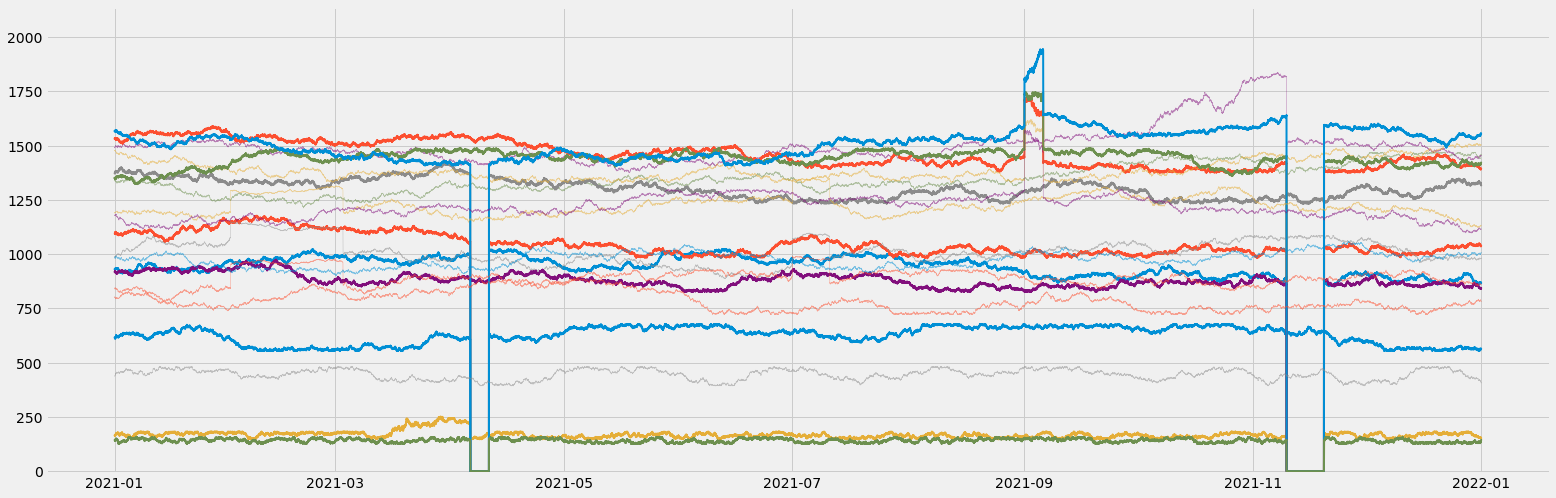

In [20]:
fig = plt.figure(figsize=(24,8))
for tag in df.columns:
    if tag in used_tags:
        plt.plot(df[tag], linewidth=2.0)
    else:
        plt.plot(df[tag], linewidth=0.5, alpha=0.5)
    
plt.ylim(-10.0, df.max().max()*1.1)
plt.show()

### Recording the failures in the dataframe

In [21]:
df['machine_status'] = 'NORMAL'
df.head()

,signal_00,signal_01,signal_02,signal_03,signal_04,signal_05,signal_06,signal_07,signal_08,signal_09,...,signal_11,signal_12,signal_13,signal_14,signal_15,signal_16,signal_17,signal_18,signal_19,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,927.029966,1094.464706,165.195132,1336.179455,1372.795411,1490.114477,615.024883,1531.592278,1477.035049,1351.472436,...,918.842112,1567.641975,843.597480,1189.205100,142.041435,438.025419,1177.158904,983.942323,803.252454,NORMAL
2021-01-01 00:10:00,927.813395,1095.248135,165.978561,1336.962884,1372.011982,1490.897906,615.808312,1530.808849,1477.818478,1352.255865,...,919.625541,1566.858546,844.380909,1189.988529,141.258006,438.808848,1177.942334,983.158894,802.469025,NORMAL
2021-01-01 00:20:00,928.596825,1094.464706,165.195132,1337.746314,1371.228553,1490.114477,615.024883,1531.592278,1477.035049,1351.472436,...,918.842112,1567.641975,843.597480,1190.771959,142.041435,438.025419,1177.158904,983.942323,803.252454,NORMAL
2021-01-01 00:30:00,929.380254,1095.248135,164.411703,1338.529743,1372.011982,1489.331048,615.808312,1530.808849,1477.818478,1350.689007,...,919.625541,1566.858546,842.814050,1189.988529,142.824865,438.808848,1177.942334,984.725753,802.469025,NORMAL
2021-01-01 00:40:00,930.163683,1094.464706,165.195132,1339.313172,1371.228553,1490.114477,616.591741,1531.592278,1478.601907,1351.472436,...,918.842112,1567.641975,842.030621,1189.205100,142.041435,438.025419,1178.725763,985.509182,801.685596,NORMAL


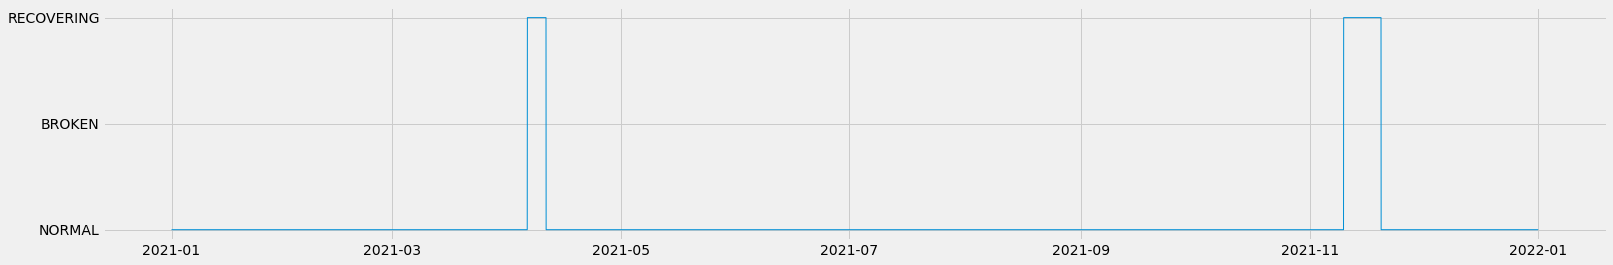

In [22]:
failure_start = np.max(anomaly_series_train.index) + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*7)
recovering_start = failure_start + relativedelta(minutes=+int(FREQ[:-3]))
recovering_end = recovering_start + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*5)
df.loc[failure_start, 'machine_status'] = 'BROKEN'
df.loc[recovering_start:recovering_end, 'machine_status'] = 'RECOVERING'

failure_start = np.max(anomaly_series_eval.index) + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*10)
recovering_start = failure_start + relativedelta(minutes=+int(FREQ[:-3]))
recovering_end = recovering_start + relativedelta(minutes=+int(FREQ[:-3]) * (60/int(FREQ[:-3]))*24*10)
df.loc[failure_start, 'machine_status'] = 'BROKEN'
df.loc[recovering_start:recovering_end, 'machine_status'] = 'RECOVERING'

fig = plt.figure(figsize=(24,4))
plt.plot(df['machine_status'])
plt.show()

## Saving the dataset
---

In [ ]:
os.makedirs(os.path.join('..', 'data', 'interim', 'synthetic'), exist_ok=True)
tags_fname = os.path.join('..', 'data', 'interim', 'synthetic', 'sensors.csv')
df.to_csv(tags_fname)